In [1]:
! pip install datasets transformers[sentencepiece]



[notice] A new release of pip available: 22.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
from transformers import AutoTokenizer, AutoModel

sentences = [
    "I took my dog for a walk",
    "Today is going to rain",
    "I took my cat for a walk",
]

model_ckpt = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

with torch.no_grad():
    model_output = model(**encoded_input)
    
    
token_embeddings = model_output.last_hidden_state
print(f"Token embeddings shape: {token_embeddings.size()}")

Token embeddings shape: torch.Size([3, 9, 384])


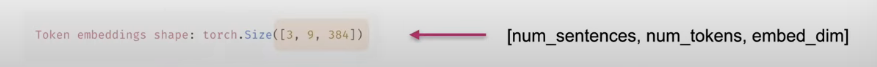

The problem here is each sentence has nice dimensions attached to it. We want to instead combine all sentences to one vector

In [3]:
import torch.nn.functional as F

# Averages the token embeddings across all sentences
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = (
        # Padding tokens are not included here using the attention_mask
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )


sentence_embeddings = mean_pooling(model_output, encoded_input["attention_mask"])
# Normalize the embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
print(f"Sentence embeddings shape: {sentence_embeddings.size()}")

Sentence embeddings shape: torch.Size([3, 384])


In [4]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

sentence_embeddings = sentence_embeddings.detach().numpy()

scores = np.zeros((sentence_embeddings.shape[0], sentence_embeddings.shape[0]))

for idx in range(sentence_embeddings.shape[0]):
    scores[idx, :] = cosine_similarity([sentence_embeddings[idx]], sentence_embeddings)[0]

print(scores)

[[1.         0.17021167 0.82909298]
 [0.17021167 0.99999976 0.17396846]
 [0.82909298 0.17396848 1.        ]]


In [5]:
from datasets import load_dataset

# Take small sample of dataset
squad = load_dataset("squad", split="validation").shuffle(seed=42).select(range(100))

# Gets embedding using mean pooling again
def get_embeddings(text_list):
    encoded_input = tokenizer(
        text_list, padding=True, truncation=True, return_tensors="pt"
    )
    encoded_input = {k: v for k, v in encoded_input.items()}
    with torch.no_grad():
        model_output = model(**encoded_input)
    return mean_pooling(model_output, encoded_input["attention_mask"])


squad_with_embeddings = squad.map(
    lambda x: {"embeddings": get_embeddings(x["context"]).cpu().numpy()[0]}
)

In [6]:
import pandas as pd
# Allows "fast nearest neighbour lookup" to allow quick comparision of embedding vectors
squad_with_embeddings.add_faiss_index(column="embeddings")

question = "Who headlined the halftime show for Super Bowl 50?"
question_embedding = get_embeddings([question]).cpu().detach().numpy()

scores, samples = squad_with_embeddings.get_nearest_examples(
    "embeddings", question_embedding, k=3
)
#print(scores)
#print(samples)
# Managed to get graph working. A little annoying they did not share
df = pd.DataFrame({
    "context": samples["context"],
    "scores": scores
})
df.head()

  0%|          | 0/1 [00:00<?, ?it/s]

,context,scores
0,"CBS broadcast Super Bowl 50 in the U.S., and c...",23.663609
1,"The league announced on October 16, 2012, that...",32.570621
2,"After a punt from both teams, Carolina got on ...",34.298470
